# Covid-19 Data Analysis

## Data Source

Source data for this notebook may be found on [GitHub](https://github.com/) at
[covid-19](https://github.com/datasets/covid-19.git).  Additional data may
be found from the [NY Times](https://github.com/nytimes/covid-19-data.git).

In [1]:
%%bash
if [ ! -d covid-19 ]; then
    git clone https://github.com/datasets/covid-19.git
    (cd covid-19; git config pull.rebase false)
else
    (cd covid-19; git pull)
fi

(cd covid-19; git log -n 1)

Cloning into 'covid-19'...
Updating files: 100% (16/16), done.
commit d6d0831a4e63af87ebc6e0828f3f42edb650ae17
Author: GitHub Action <action@github.com>
Date:   Sun Apr 17 06:16:05 2022 +0000

    Auto-update of the data packages


In [2]:
%%bash
ls covid-19/data

countries-aggregated.csv
key-countries-pivoted.csv
reference.csv
time-series-19-covid-combined.csv
us_confirmed.csv
us_deaths.csv
us_simplified.csv
worldwide-aggregate.csv


# Dependencies

In [3]:
%%pom
---
dependencies:
- org.knowm.xchart:xchart:LATEST

## Spark

In [4]:
%%spark-session local[*] covid-19

local[*]

In [5]:
import org.apache.spark.*;
import org.apache.spark.sql.*;
import org.apache.spark.sql.types.*;

import static org.apache.spark.sql.functions.*;

var session = SparkSession.active();
var reader = session.read().option("header", true).option("inferSchema", true);

var countries_aggregated =
    reader.csv("covid-19/data/countries-aggregated.csv")
    .withColumn("Date", col("Date").cast(DataTypes.DateType));
var key_countries_pivoted =
    reader.csv("covid-19/data/key-countries-pivoted.csv")
    .withColumn("Date", col("Date").cast(DataTypes.DateType));
var reference = reader.csv("covid-19/data/reference.csv");
var time_series_19_covid_combined =
    reader.csv("covid-19/data/time-series-19-covid-combined.csv")
    .withColumn("Date", col("Date").cast(DataTypes.DateType));
var us_confirmed =
    reader.csv("covid-19/data/us_confirmed.csv")
    .withColumn("Date", col("Date").cast(DataTypes.DateType));
var us_deaths =
    reader.csv("covid-19/data/us_deaths.csv")
    .withColumn("Date", col("Date").cast(DataTypes.DateType));
var us_simplified =
    reader.csv("covid-19/data/us_simplified.csv")
    .withColumn("Date", col("Date").cast(DataTypes.DateType));
var worldwide_aggregate =
    reader.csv("covid-19/data/worldwide-aggregate.csv")
    .withColumn("Date", col("Date").cast(DataTypes.DateType));

In [6]:
us_simplified.printSchema();

root
 |-- Date: date (nullable = true)
 |-- Admin2: string (nullable = true)
 |-- Province/State: string (nullable = true)
 |-- Confirmed: integer (nullable = true)
 |-- Deaths: integer (nullable = true)
 |-- Country/Region: string (nullable = true)



In [7]:
us_simplified.show(40);

+----------+-------+--------------+---------+------+--------------+
|      Date| Admin2|Province/State|Confirmed|Deaths|Country/Region|
+----------+-------+--------------+---------+------+--------------+
|2020-01-22|Autauga|       Alabama|        0|     0|            US|
|2020-01-23|Autauga|       Alabama|        0|     0|            US|
|2020-01-24|Autauga|       Alabama|        0|     0|            US|
|2020-01-25|Autauga|       Alabama|        0|     0|            US|
|2020-01-26|Autauga|       Alabama|        0|     0|            US|
|2020-01-27|Autauga|       Alabama|        0|     0|            US|
|2020-01-28|Autauga|       Alabama|        0|     0|            US|
|2020-01-29|Autauga|       Alabama|        0|     0|            US|
|2020-01-30|Autauga|       Alabama|        0|     0|            US|
|2020-01-31|Autauga|       Alabama|        0|     0|            US|
|2020-02-01|Autauga|       Alabama|        0|     0|            US|
|2020-02-02|Autauga|       Alabama|        0|   

In [8]:
import java.util.Map;

var by_state =
    us_simplified
    .groupBy("Country/Region", "Province/State")
    .agg(Map.of("Deaths", "max"))
    .orderBy("max(Deaths)");

In [9]:
by_state.show(100);

+--------------+--------------------+-----------+
|Country/Region|      Province/State|max(Deaths)|
+--------------+--------------------+-----------+
|            US|    Diamond Princess|          0|
|            US|      Grand Princess|          3|
|            US|      American Samoa|         18|
|            US|Northern Mariana ...|         34|
|            US|      Virgin Islands|        111|
|            US|             Vermont|        167|
|            US|             Wyoming|        290|
|            US|        North Dakota|        333|
|            US|                Guam|        354|
|            US|               Maine|        357|
|            US|        South Dakota|        514|
|            US|              Alaska|        523|
|            US|             Montana|        547|
|            US|       West Virginia|        721|
|            US|         Mississippi|        788|
|            US|       New Hampshire|        905|
|            US|               Idaho|       1017|


In [10]:
var dates = time_series_19_covid_combined.select("Date").distinct().orderBy("Date");
var interval = dates.agg(min("Date"), max("Date")).head();
var snapshot =
    time_series_19_covid_combined
    .filter(col("Date").leq(interval.get(1)))
    .groupBy(col("Country/Region"))
    .agg(max(col("Deaths")).as("Deaths"))
    .orderBy(desc("Deaths"));

print(snapshot);

,Country/Region,Deaths
0,US,988609
1,Brazil,662185
2,India,521751
3,Russia,365774
4,Mexico,323938
5,Peru,212619
6,United Kingdom,171396
7,Italy,161602
8,Indonesia,155844
9,France,140952


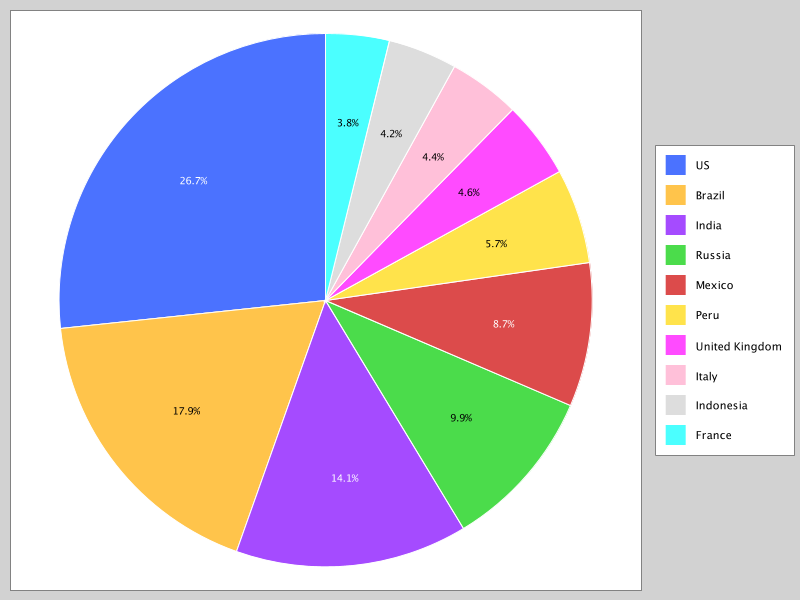

In [11]:
import org.knowm.xchart.*;

var chart = new PieChartBuilder().width(800).height(600).build();

snapshot.collectAsList().stream().limit(10).forEach(r -> chart.addSeries(r.getAs(0), r.getAs(1)));

print(chart);

In [12]:
%%java

Name,Type,Value
$$,ganymede.notebook.NotebookContext,NotebookContext(super=ganymede.notebook.NotebookContext@2e463f4)
by_state,org.apache.spark.sql.Dataset<Row>,"[Country/Region: string, Province/State: string ... 1 more field]"
chart,org.knowm.xchart.PieChart,org.knowm.xchart.PieChart@7e5b34c1
countries_aggregated,org.apache.spark.sql.Dataset<Row>,"[Date: date, Country: string ... 3 more fields]"
dates,org.apache.spark.sql.Dataset<Row>,[Date: date]
interval,org.apache.spark.sql.Row,"[2020-01-22,2022-04-16]"
key_countries_pivoted,org.apache.spark.sql.Dataset<Row>,"[Date: date, China: int ... 7 more fields]"
reader,org.apache.spark.sql.DataFrameReader,org.apache.spark.sql.DataFrameReader@1e489957
reference,org.apache.spark.sql.Dataset<Row>,"[UID: int, iso2: string ... 10 more fields]"
session,org.apache.spark.sql.SparkSession,org.apache.spark.sql.SparkSession@4af44f2a
